# Convolutional Autoencoder and Anomaly Detection
## Learning Objectives
1. learn how to build Deep Convolutional Autoencoder
2. Learn how to use trained Autoencoder for anomaly detection

## Preparation
### Import Dependencies



In [1]:
# Import libraries and modules
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

np.set_printoptions(threshold=np.inf)

### Visualization utilities

In [2]:
def plot_latent_space(decoder, n=30, ranges=[-1, 1, -1, 1], figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(ranges[0], ranges[1], n)
    grid_y = np.linspace(ranges[2], ranges[3], n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


def plot_label_clusters(encoder, data, labels, vae=True):
    # display a 2D plot of the digit classes in the latent space
    if vae:
        z_mean, _, _ = encoder.predict(data)
    else:
        z_mean = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    for label in range(10):  # mnist, 10 digits
        cx = np.mean(z_mean[labels == label, 0])
        cy = np.mean(z_mean[labels == label, 1])
        plt.text(
            cx, cy, str(label), color="white", fontsize=25, fontweight="bold"
        )
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

### Load MNIST Data

Use Keras utilities to load MNIST data

In [3]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

## Build Autoencoder

### Encoder
The encoder goes from the inputs to the latent dim:

In [4]:
latent_dim = 2  # for easy visualization

encoder = tf.keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1), name="image_input"),
        layers.Conv2D(
            32, 3, activation="relu", strides=2, padding="same", name="e_conv1"
        ),
        layers.Conv2D(
            64, 3, activation="relu", strides=2, padding="same", name="e_conv2"
        ),
        layers.Flatten(name="e_flatten"),
        layers.Dense(latent_dim, name="e_dense"),
    ],
    name="encoder",
)
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
e_conv1 (Conv2D)             (None, 14, 14, 32)        320       
_________________________________________________________________
e_conv2 (Conv2D)             (None, 7, 7, 64)          18496     
_________________________________________________________________
e_flatten (Flatten)          (None, 3136)              0         
_________________________________________________________________
e_dense (Dense)              (None, 2)                 6274      
Total params: 25,090
Trainable params: 25,090
Non-trainable params: 0
_________________________________________________________________


2022-04-20 05:26:36.496426: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 05:26:36.511269: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 05:26:36.512196: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 05:26:36.513522: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Decoder
The decoder goes from the latent dim back to the reconstructed image:

In [5]:
decoder = tf.keras.Sequential(
    [
        keras.Input(shape=(latent_dim,), name="d_input"),
        layers.Dense(7 * 7 * 64, activation="relu", name="d_d1"),
        layers.Reshape((7, 7, 64), name="d_d2"),
        layers.Conv2DTranspose(
            32, 3, activation="relu", strides=2, padding="same", name="d_conv1"
        ),
        layers.Conv2DTranspose(
            1,
            3,
            activation="sigmoid",
            strides=2,
            padding="same",
            name="d_conv2",
        ),
    ],
    name="decoder",
)
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d_d1 (Dense)                 (None, 3136)              9408      
_________________________________________________________________
d_d2 (Reshape)               (None, 7, 7, 64)          0         
_________________________________________________________________
d_conv1 (Conv2DTranspose)    (None, 14, 14, 32)        18464     
_________________________________________________________________
d_conv2 (Conv2DTranspose)    (None, 28, 28, 1)         289       
Total params: 28,161
Trainable params: 28,161
Non-trainable params: 0
_________________________________________________________________


### Construct entire autoencoder

The autoencoder consists of the encoder and the decoder blocks. We can write it as a Keras Functional model

In [6]:
encoder_inputs = keras.Input(shape=(28, 28, 1), name="image_input")
x = encoder(encoder_inputs)
decoder_output = decoder(x)
autoencoder = keras.Model(encoder_inputs, decoder_output, name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Sequential)         (None, 2)                 25090     
_________________________________________________________________
decoder (Sequential)         (None, 28, 28, 1)         28161     
Total params: 53,251
Trainable params: 53,251
Non-trainable params: 0
_________________________________________________________________


## Train autoencoder

In [7]:
autoencoder.compile(optimizer=keras.optimizers.Adam(), loss="mse")
history = autoencoder.fit(mnist_digits, mnist_digits, epochs=30, batch_size=128)

2022-04-20 05:26:37.772103: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-04-20 05:26:38.780313: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200


547/547 [==============================] - 5s 4ms/step - loss: 0.0700
Epoch 2/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0526
Epoch 3/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0502
Epoch 4/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0479
Epoch 5/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0465
Epoch 6/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0456
Epoch 7/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0449
Epoch 8/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0443
Epoch 9/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0439
Epoch 10/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0435
Epoch 11/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0431
Epoch 12/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0429
Epoch 13/30
547/547 [===============

## Visualize the latent space

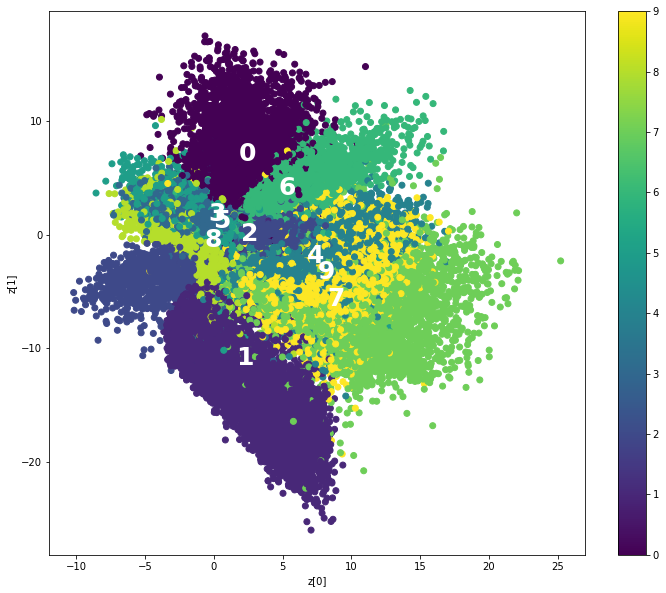

In [8]:
(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
plot_label_clusters(encoder, x_train, y_train, vae=False)

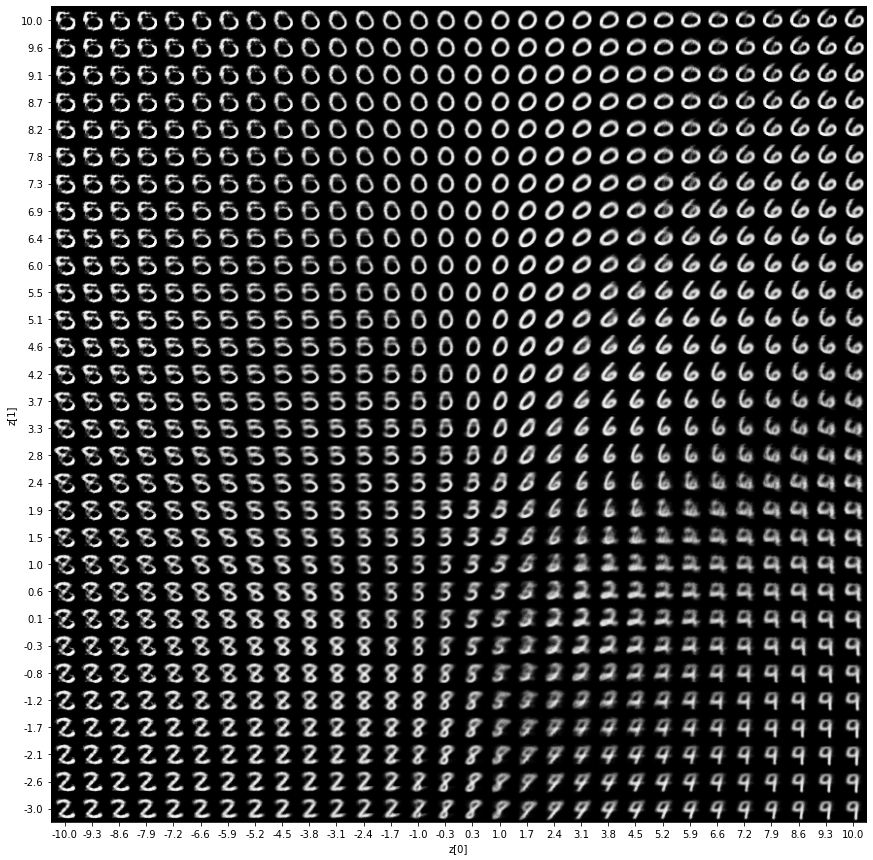

In [9]:
plot_latent_space(decoder, n=30, ranges=[-10, 10, -3, 10], figsize=15)

## Anomaly Detection
Now we confirmed how Autoencoder works. Let's create performant model by specifying lager latent dimetion.

### Build AutoEncoder for Anomaly Detection

In [10]:
def build_autoencoder(latent_dim=8):
    decoder = tf.keras.Sequential(
        [
            keras.Input(shape=(latent_dim,), name="d_input"),
            layers.Dense(7 * 7 * 64, activation="relu", name="d_d1"),
            layers.Reshape((7, 7, 64), name="d_d2"),
            layers.Conv2DTranspose(
                32,
                3,
                activation="relu",
                strides=2,
                padding="same",
                name="d_conv1",
            ),
            layers.Conv2DTranspose(
                1,
                3,
                activation="sigmoid",
                strides=2,
                padding="same",
                name="d_conv2",
            ),
        ],
        name="decoder",
    )

    encoder = tf.keras.Sequential(
        [
            keras.Input(shape=(28, 28, 1), name="image_input"),
            layers.Conv2D(
                32,
                3,
                activation="relu",
                strides=2,
                padding="same",
                name="e_conv1",
            ),
            layers.Conv2D(
                64,
                3,
                activation="relu",
                strides=2,
                padding="same",
                name="e_conv2",
            ),
            layers.Flatten(name="e_flatten"),
            layers.Dense(latent_dim, name="e_dense"),
        ],
        name="encoder",
    )

    encoder_inputs = keras.Input(shape=(28, 28, 1), name="image_input")
    x = encoder(encoder_inputs)
    decoder_output = decoder(x)
    autoencoder = keras.Model(
        encoder_inputs, decoder_output, name="autoencoder"
    )
    autoencoder.summary()

    autoencoder.compile(optimizer=keras.optimizers.Adam(), loss="mse")

    return autoencoder

In [11]:
autoencoder = build_autoencoder(latent_dim=32)

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Sequential)         (None, 32)                119200    
_________________________________________________________________
decoder (Sequential)         (None, 28, 28, 1)         122241    
Total params: 241,441
Trainable params: 241,441
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = autoencoder.fit(mnist_digits, mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 3s 4ms/step - loss: 0.0437
Epoch 2/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0076
Epoch 3/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0058
Epoch 4/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0052
Epoch 5/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0048
Epoch 6/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0045
Epoch 7/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0043
Epoch 8/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0042
Epoch 9/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0041
Epoch 10/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0039
Epoch 11/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0039
Epoch 12/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0038
Epoch 13/30
547/547 [====

### Setup threshold

In [13]:
num_sample = 2000  # Number of samples to caliculate threshold

reconstructions = autoencoder.predict(x_train[:num_sample])
train_loss = tf.reduce_mean(
    tf.keras.losses.mae(reconstructions, x_train[:num_sample]), axis=(1, 2)
)

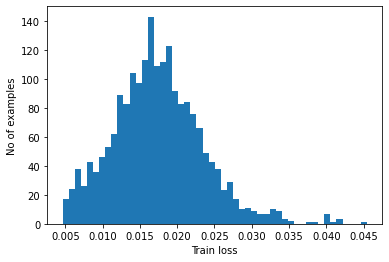

In [14]:
# Visualize histgram of loss value
plt.hist(train_loss[None, :], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [15]:
# Define Anomaly Threshold
sigma = 2

threshold = np.mean(train_loss) + np.std(train_loss) * sigma
print("Threshold: ", threshold)

Threshold:  0.029475636780261993


In [16]:
# Detection function
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.reduce_mean(
        tf.keras.losses.mae(reconstructions, data), axis=(1, 2)
    )
    return tf.math.greater(loss, threshold), loss[0], reconstructions

In [17]:
# Ploting Utility Function
def plot_reconstruction(model, data, threshold):
    is_anomaly, loss, reconstruction = predict(
        model, tf.expand_dims(data, 0), threshold
    )

    f, axarr = plt.subplots(1, 2)
    lossMSG = f"loss:{loss:.4f}"
    thMSG = f"threshold:{threshold:.4f}"
    text_anomaly = (
        f"Anomaly ({lossMSG} > {thMSG})"
        if is_anomaly
        else f"Normal ({lossMSG} <= {thMSG})"
    )
    title = f.suptitle(text_anomaly)
    c = "r" if is_anomaly else "g"
    plt.setp(title, color=c)

    axarr[0].imshow(data)
    axarr[0].set_title("Original Image")
    axarr[1].imshow(reconstruction[0])
    axarr[1].set_title("Reconstructed Image")
    f.show()

### Let's try to predict on normal data

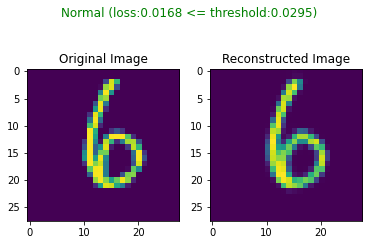

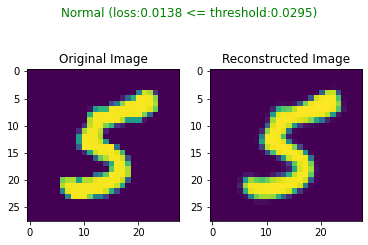

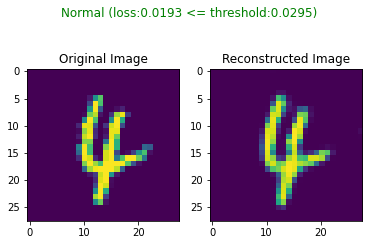

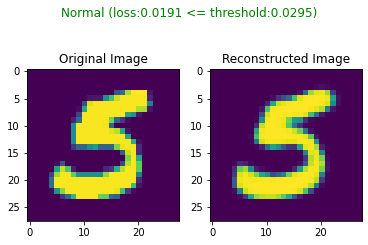

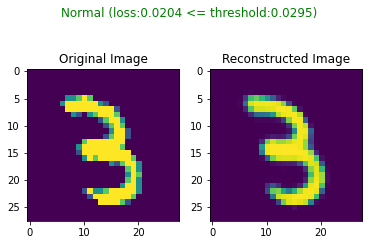

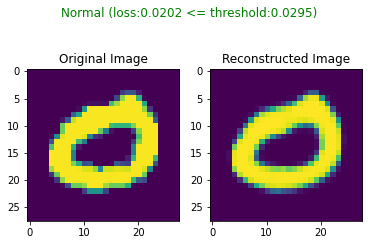

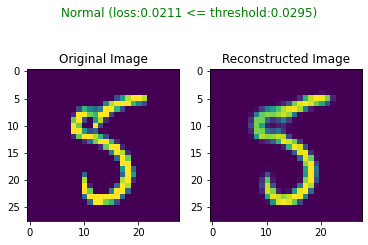

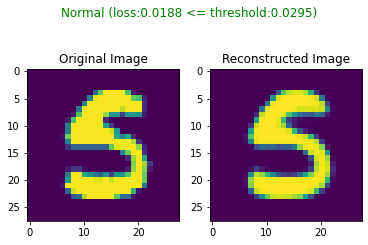

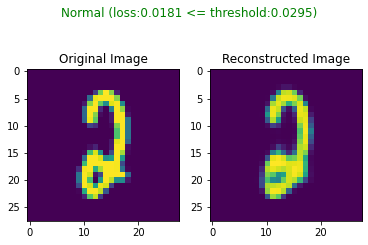

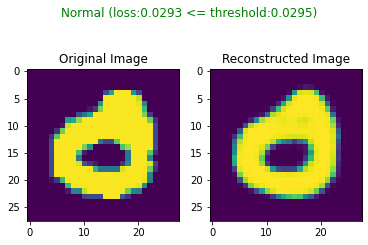

In [18]:
for d in x_train[num_sample - 10 : num_sample]:
    plot_reconstruction(autoencoder, d, threshold)

### Try Anomaly Detections
Looks Like our autoencoder is reconstructing images very well!

Then what happens when it get 'unusual' data?

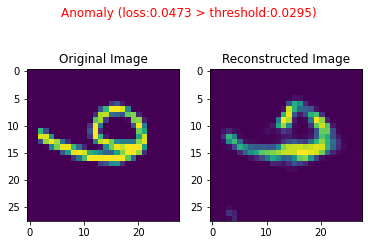

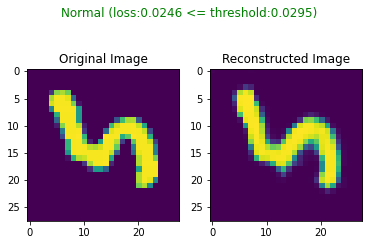

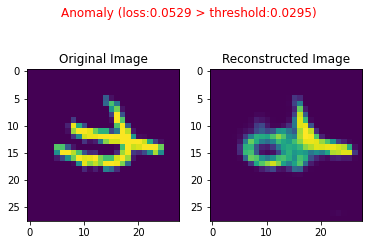

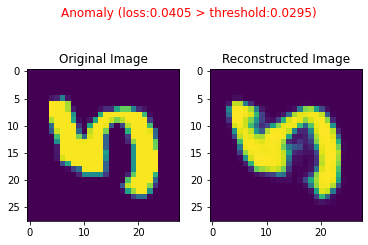

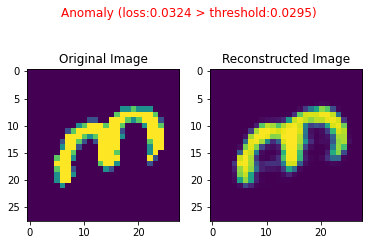

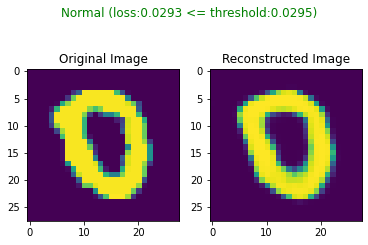

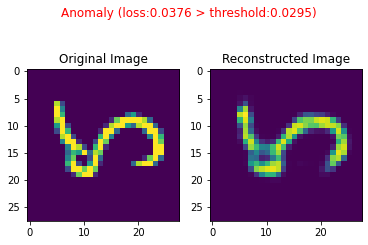

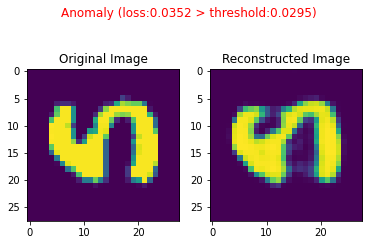

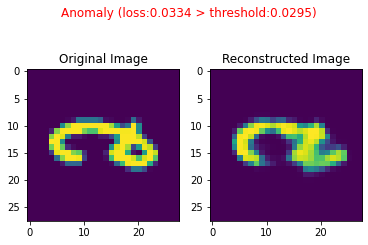

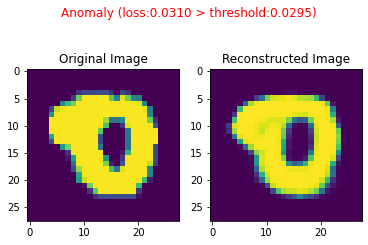

In [19]:
# Let's try to rotate the image
for d in x_train[num_sample - 10 : num_sample]:
    plot_reconstruction(autoencoder, np.rot90(d), threshold)

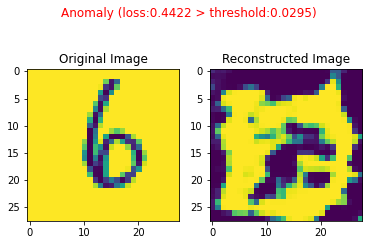

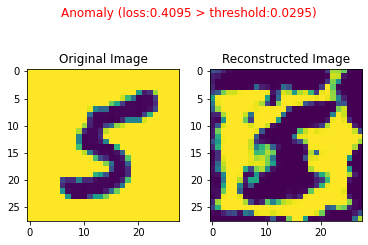

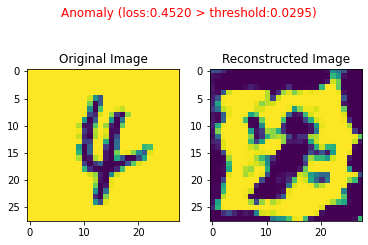

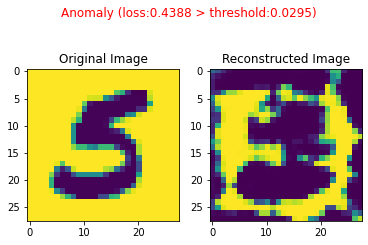

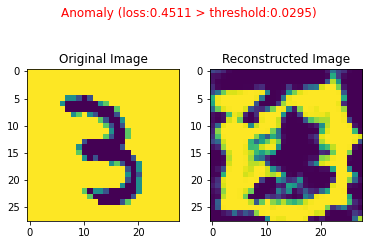

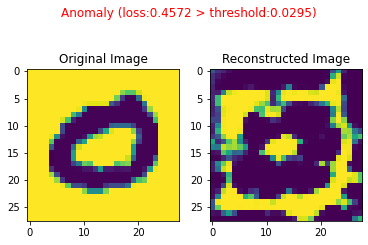

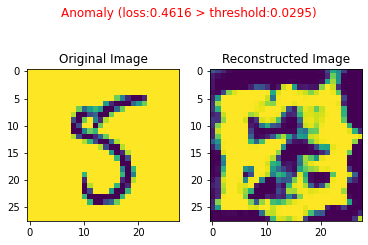

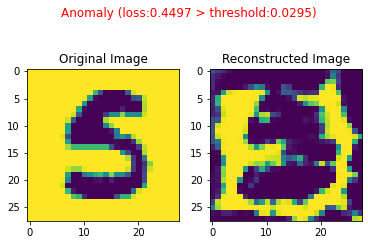

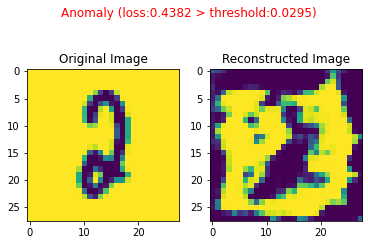

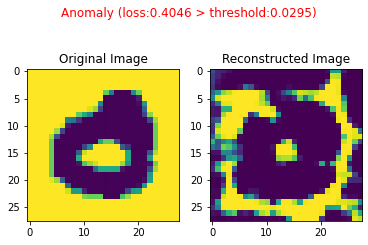

In [20]:
# Negatives
for d in x_train[num_sample - 10 : num_sample]:
    plot_reconstruction(autoencoder, 1 - d, threshold)

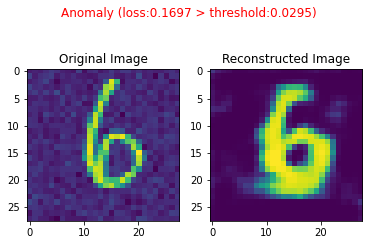

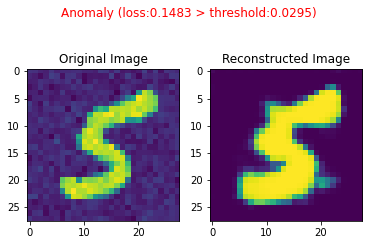

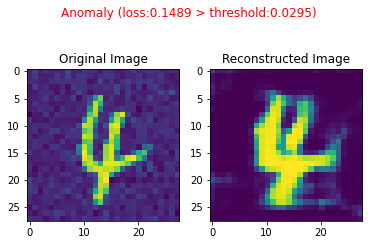

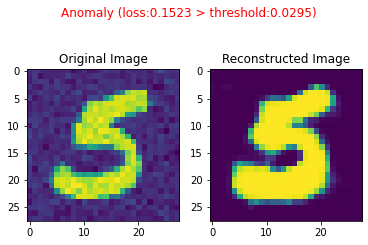

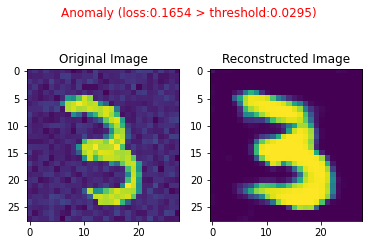

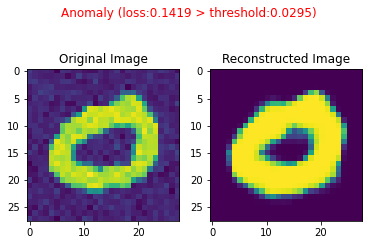

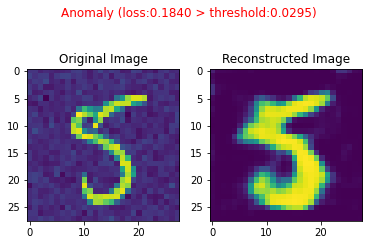

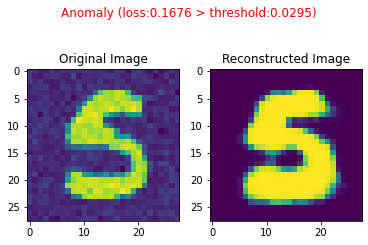

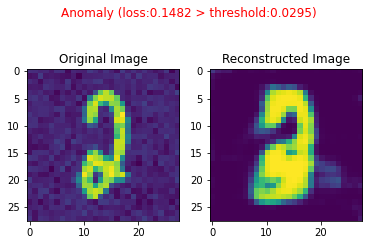

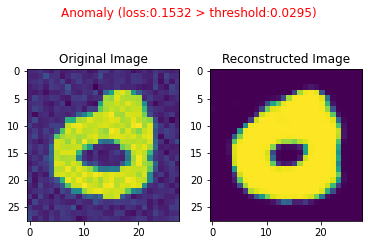

In [21]:
# Add White Noise
def add_noise_and_scale(d):
    noise = np.random.normal(0, 0.05, size=(28, 28, 1))
    _d = d + noise
    return _d - np.min(_d) / (np.max(_d) - np.min(_d))


for d in x_train[num_sample - 10 : num_sample]:
    plot_reconstruction(autoencoder, add_noise_and_scale(d), threshold)

Since our autoencoder was trained with clean image, it try to 'denoise' and generate clean images.

As a result, the error between noizy input and clean output becomes large, and it detected as anomaly.

Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.